# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


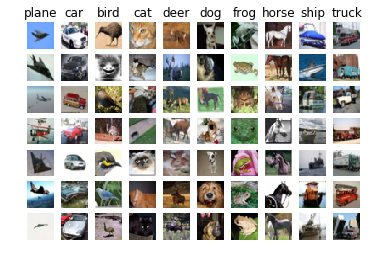

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


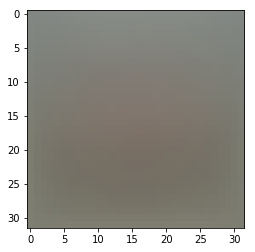

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [11]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.691090


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [31]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -4.027390 analytic: -4.027390, relative error: 2.757673e-12
numerical: 45.356058 analytic: 45.356058, relative error: 1.443220e-12
numerical: 16.482500 analytic: 16.482500, relative error: 1.333240e-11
numerical: 19.713689 analytic: 19.747878, relative error: 8.663984e-04
numerical: -19.688682 analytic: -19.688682, relative error: 1.378668e-11
numerical: -15.377801 analytic: -15.377801, relative error: 3.346509e-12
numerical: 6.712647 analytic: 6.712647, relative error: 1.620703e-11
numerical: 8.619586 analytic: 8.619586, relative error: 4.134834e-11
numerical: 13.578552 analytic: 13.578552, relative error: 1.072600e-11
numerical: -9.498216 analytic: -9.498216, relative error: 2.497466e-12
numerical: 14.198887 analytic: 14.198887, relative error: 8.275657e-12
numerical: 8.042494 analytic: 8.042494, relative error: 1.824674e-11
numerical: -12.623459 analytic: -12.623459, relative error: 2.182315e-11
numerical: -14.385946 analytic: -14.385946, relative error: 3.340801e-11
nume

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** The derivative of the SVM loss function is not continuous. At the 'hinge' a forward and backward derivative would compute different numbers. This is not a reason for concern, any undesirable changes to any of the model parameters we invert for would be corrected by subsequent steps of gradient descent when the gradient for that model parameter would be correct (no longer perfectly at the hinge point).

In [34]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.691090e+00 computed in 0.106078s
Vectorized loss: 8.691090e+00 computed in 0.003186s
difference: -0.000000


In [35]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.098438s
Vectorized loss and gradient: computed in 0.003533s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [45]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 800.742565
iteration 100 / 1500: loss 292.073334
iteration 200 / 1500: loss 109.057849
iteration 300 / 1500: loss 42.904378
iteration 400 / 1500: loss 19.340983
iteration 500 / 1500: loss 10.615173
iteration 600 / 1500: loss 6.847253
iteration 700 / 1500: loss 5.949042
iteration 800 / 1500: loss 5.687028
iteration 900 / 1500: loss 5.245141
iteration 1000 / 1500: loss 5.792943
iteration 1100 / 1500: loss 5.475196
iteration 1200 / 1500: loss 5.251037
iteration 1300 / 1500: loss 5.188309
iteration 1400 / 1500: loss 4.929324
That took 3.162616s


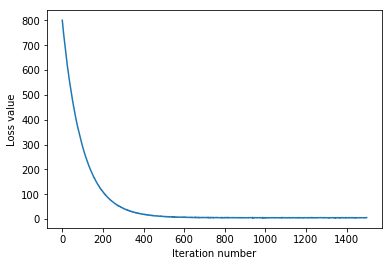

In [46]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [47]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.370000
validation accuracy: 0.383000


In [57]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.

learning_rates = np.log10([1e-7, 5e-6])
regularization_strengths = np.log10([5e3, 6e4])

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

num_params = 50
range_lr = np.logspace(learning_rates[0],learning_rates[1],num_params)
range_reg = np.logspace(regularization_strengths[0],regularization_strengths[1],num_params)

range_lr = range_lr[np.random.permutation(num_params)]
range_reg = range_reg[np.random.permutation(num_params)]

for learning_rate, regularization_strength in zip(range_lr, range_reg):
    #train
    print("Starting iteration with rate %e and regstrength %e"%(learning_rate,regularization_strength))
    svm = LinearSVM()
    loss_hist = svm.train(X_train, y_train, learning_rate=learning_rate, reg=regularization_strength,
                          num_iters=1500, verbose=True)
    
    y_train_pred = svm.predict(X_train)
    train_acc = np.mean(y_train == y_train_pred)
    print('training accuracy: %f' % train_acc)
    y_val_pred = svm.predict(X_val)
    val_acc = np.mean(y_val == y_val_pred)
    print('validation accuracy: %f' % val_acc)
    print('\n')
    
    results[(learning_rate,regularization_strength)]=(train_acc,val_acc)
    if val_acc > best_val:
        best_val = val_acc
        best_svm = svm
          
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Starting iteration with rate 4.558105e-07 and regstrength 5.000000e+03
iteration 0 / 1500: loss 172.923297
iteration 100 / 1500: loss 65.777844
iteration 200 / 1500: loss 29.793526
iteration 300 / 1500: loss 14.811136
iteration 400 / 1500: loss 8.696019
iteration 500 / 1500: loss 6.114062
iteration 600 / 1500: loss 5.698801
iteration 700 / 1500: loss 5.179307
iteration 800 / 1500: loss 5.508197
iteration 900 / 1500: loss 5.248717
iteration 1000 / 1500: loss 5.006919
iteration 1100 / 1500: loss 5.149014
iteration 1200 / 1500: loss 4.822864
iteration 1300 / 1500: loss 4.905667
iteration 1400 / 1500: loss 4.728571
training accuracy: 0.359388
validation accuracy: 0.374000


Starting iteration with rate 2.077632e-06 and regstrength 4.656190e+04
iteration 0 / 1500: loss 1462.949299
iteration 100 / 1500: loss 10.191526
iteration 200 / 1500: loss 11.895534
iteration 300 / 1500: loss 14.552551
iteration 400 / 1500: loss 9.714062
iteration 500 / 1500: loss 13.256826
iteration 600 / 1500: loss 13

iteration 100 / 1500: loss 196.707120
iteration 200 / 1500: loss 48.486072
iteration 300 / 1500: loss 14.807603
iteration 400 / 1500: loss 7.937078
iteration 500 / 1500: loss 6.009709
iteration 600 / 1500: loss 5.895137
iteration 700 / 1500: loss 5.225719
iteration 800 / 1500: loss 5.166231
iteration 900 / 1500: loss 5.526903
iteration 1000 / 1500: loss 5.358859
iteration 1100 / 1500: loss 5.031973
iteration 1200 / 1500: loss 5.053226
iteration 1300 / 1500: loss 5.086095
iteration 1400 / 1500: loss 5.441206
training accuracy: 0.355653
validation accuracy: 0.358000


Starting iteration with rate 3.587284e-07 and regstrength 7.130808e+03
iteration 0 / 1500: loss 238.886150
iteration 100 / 1500: loss 83.533941
iteration 200 / 1500: loss 32.921467
iteration 300 / 1500: loss 15.022754
iteration 400 / 1500: loss 8.167355
iteration 500 / 1500: loss 6.581824
iteration 600 / 1500: loss 5.607461
iteration 700 / 1500: loss 5.605821
iteration 800 / 1500: loss 6.484793
iteration 900 / 1500: loss 4.

iteration 200 / 1500: loss 5.719689
iteration 300 / 1500: loss 5.645540
iteration 400 / 1500: loss 5.710201
iteration 500 / 1500: loss 5.853019
iteration 600 / 1500: loss 6.112702
iteration 700 / 1500: loss 6.066384
iteration 800 / 1500: loss 5.845548
iteration 900 / 1500: loss 5.953643
iteration 1000 / 1500: loss 5.177353
iteration 1100 / 1500: loss 6.425005
iteration 1200 / 1500: loss 5.842051
iteration 1300 / 1500: loss 5.516424
iteration 1400 / 1500: loss 6.235706
training accuracy: 0.340061
validation accuracy: 0.349000


Starting iteration with rate 1.393812e-06 and regstrength 9.188810e+03
iteration 0 / 1500: loss 304.935230
iteration 100 / 1500: loss 9.570237
iteration 200 / 1500: loss 6.909851
iteration 300 / 1500: loss 6.547761
iteration 400 / 1500: loss 6.532778
iteration 500 / 1500: loss 6.107223
iteration 600 / 1500: loss 8.763389
iteration 700 / 1500: loss 7.059812
iteration 800 / 1500: loss 8.190559
iteration 900 / 1500: loss 7.695080
iteration 1000 / 1500: loss 6.104569

iteration 300 / 1500: loss 6.219421
iteration 400 / 1500: loss 6.623553
iteration 500 / 1500: loss 6.130016
iteration 600 / 1500: loss 6.596151
iteration 700 / 1500: loss 6.674992
iteration 800 / 1500: loss 7.186066
iteration 900 / 1500: loss 6.343018
iteration 1000 / 1500: loss 5.732304
iteration 1100 / 1500: loss 6.054118
iteration 1200 / 1500: loss 6.932152
iteration 1300 / 1500: loss 6.750982
iteration 1400 / 1500: loss 7.139533
training accuracy: 0.300592
validation accuracy: 0.308000


Starting iteration with rate 1.000000e-07 and regstrength 3.434678e+04
iteration 0 / 1500: loss 1069.160397
iteration 100 / 1500: loss 268.550214
iteration 200 / 1500: loss 71.349046
iteration 300 / 1500: loss 22.083987
iteration 400 / 1500: loss 9.213569
iteration 500 / 1500: loss 6.444195
iteration 600 / 1500: loss 6.214514
iteration 700 / 1500: loss 5.196901
iteration 800 / 1500: loss 5.389445
iteration 900 / 1500: loss 5.690336
iteration 1000 / 1500: loss 4.976692
iteration 1100 / 1500: loss 5.

iteration 400 / 1500: loss 8.830980
iteration 500 / 1500: loss 12.347588
iteration 600 / 1500: loss 9.480130
iteration 700 / 1500: loss 12.777357
iteration 800 / 1500: loss 12.549758
iteration 900 / 1500: loss 12.070729
iteration 1000 / 1500: loss 13.502007
iteration 1100 / 1500: loss 12.770475
iteration 1200 / 1500: loss 9.936035
iteration 1300 / 1500: loss 10.778334
iteration 1400 / 1500: loss 12.442911
training accuracy: 0.240531
validation accuracy: 0.257000


Starting iteration with rate 5.791657e-07 and regstrength 3.801319e+04
iteration 0 / 1500: loss 1177.102566
iteration 100 / 1500: loss 7.215207
iteration 200 / 1500: loss 5.539656
iteration 300 / 1500: loss 6.014876
iteration 400 / 1500: loss 6.145007
iteration 500 / 1500: loss 5.947560
iteration 600 / 1500: loss 5.904867
iteration 700 / 1500: loss 5.360044
iteration 800 / 1500: loss 5.513976
iteration 900 / 1500: loss 5.995345
iteration 1000 / 1500: loss 5.175536
iteration 1100 / 1500: loss 5.506201
iteration 1200 / 1500: lo

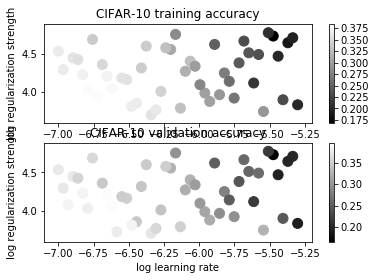

In [58]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [59]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.381000


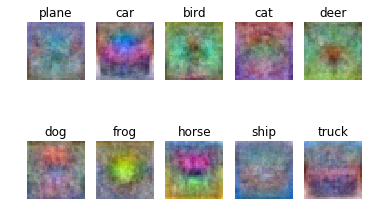

In [60]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*

In [ ]:
They look like average images of the objects they represent. Most images of that class in the training set would have comparatively small distance to this average image and would therefore have a good chance of having the classifier return the right result (with well understood limitations that direct pixel comparison as is done here is sensitive to translation/rotation etc)